# HW5-1. NN

## < Contents >  
 > 0. Preprocessing 
 > 1. NO partitioning 
 > 2. Partitioning train/test 
 > 3. CV
 
 > **CF ) R ver 3.6.3에서 기존 코드에 있던 neuralnet 함수가 작동하지 않는 것을 확인하였고, 
     따라서 비슷한 NN 역할을 하는 nnet 함수를 사용.** 
 
 


## 0. Preprocessing 

NN 연산을 위해 4가지 변수 (age, balance, day, duration)만 사용하였고, 표준화 해주었음. 

In [43]:
# install.packages("neuralnet")
# install.packages("dummy")
# install.packages("nnet")
# install.packages("devtools")

library(nnet)
library(neuralnet) 
library(dummy) 
bank = read.csv("bank-default2.csv",header=T)
head(bank, 3)

bank$y = ifelse(bank$y == " yes", 1, 0)     # yes = 1, no = 0
bank$y = factor(bank$y) 
print(sum(is.na(bank)))            # 총 11개의 결측치가 존재 
bank = na.omit(bank)  

y = bank[, 17]    # 정기예금 가입 여부

# numerical variable만 사용 
X = bank[, c(1,6, 10, 12)]   

max1 = apply(X, 2, max) 
min1 = apply(X, 2, min)

gdat = scale(X, center = min1, scale = max1 - min1) #Standaization
gdat = as.data.frame(gdat)
# target 
gdat['y'] = y

## 1. NO partition 

히든 노드의 수를 3으로 설정하고 NN 모델링을 진행

In [36]:
# Model fitting 
gn = names(gdat)
f = as.formula(paste("y ~", paste(gn[!gn %in% "y"], collapse = " + "))) 
fit.nn = nnet(f, data = gdat, size=3)     # nnet의 size는 히든 노드의 수를 뜻함

# weights:  19
initial  value 57529.604624 
iter  10 value 14374.918668
iter  20 value 13154.619235
iter  30 value 12911.642546
iter  40 value 12860.787617
iter  50 value 12817.768896
iter  60 value 12772.297623
iter  70 value 12745.889102
iter  80 value 12735.867526
iter  90 value 12720.688817
iter 100 value 12706.727382
final  value 12706.727382 
stopped after 100 iterations


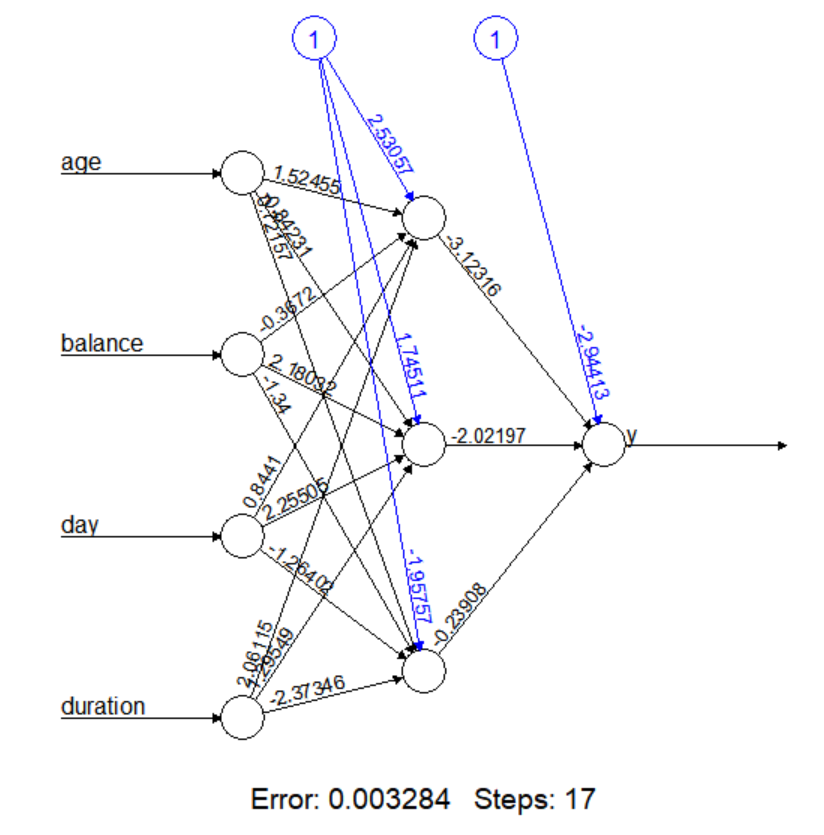

> 참고 ) 이거 그림은 neuralnet 함수에서 그린건데, 아래 ERROR는 우리 fitting 결과랑 다르니까 ERROR 빼고 그냥 위에 은닉층 그림만 참고용으로 쓰는 것도 좋을듯 !

In [31]:
## Prediction 

cutoff = 0.5
p.nn = predict(fit.nn, gdat)
yhat.nn = ifelse(p.nn > cutoff, 1, 0)

ctable = table(gdat$y, yhat.nn, dnn=c("Actual","Predicted"))
print(ctable) # classification table  


      Predicted
Actual     0     1
     0 39301   612
     1  4405   882


> Prediction 결과 실제로 정기예금에 가입하지 않았는데 가입했다고 예측한 오분류보다, 가입했는데 가입하지 않았다고 예측한 오분류가 약 7배 더 많습니다. 이는 앞서 LDA, KNN 등의 모델보다 더욱 높은 오분류 양상으로 그 원인은 NN의 연산량을 고려해 bank data의 변수를 4가지로 제약하여 나타난 것으로 추정됩니다. 

In [33]:
## Evaluating

miss.err = 1-sum(diag(ctable))/sum(ctable) # Misclassification Rate
miss.err

pred.acc = 1 - miss.err #Prediction Accuracy
pred.acc  

diag(ctable)[2]/apply(ctable, 1, sum)[2] # Sensitivity
diag(ctable)[1]/apply(ctable, 1, sum)[1] # Specificity

[1] 0.1109956

[1] 0.8890044

1 
0.1668243

0 
0.9846666

> 앞선 confusion matrix 결과와 같이 민감도 또한 매우 낮은 수치를 보이고 있고, 앞선 KNN, LDA, QDA 등의 선형모델보다 낮습니다. Missclassification error와 prediction accuracy는 앞선 선형 모델들과 매우 유사한 수준입니다.  

[[1]]
[1] 0.8163406

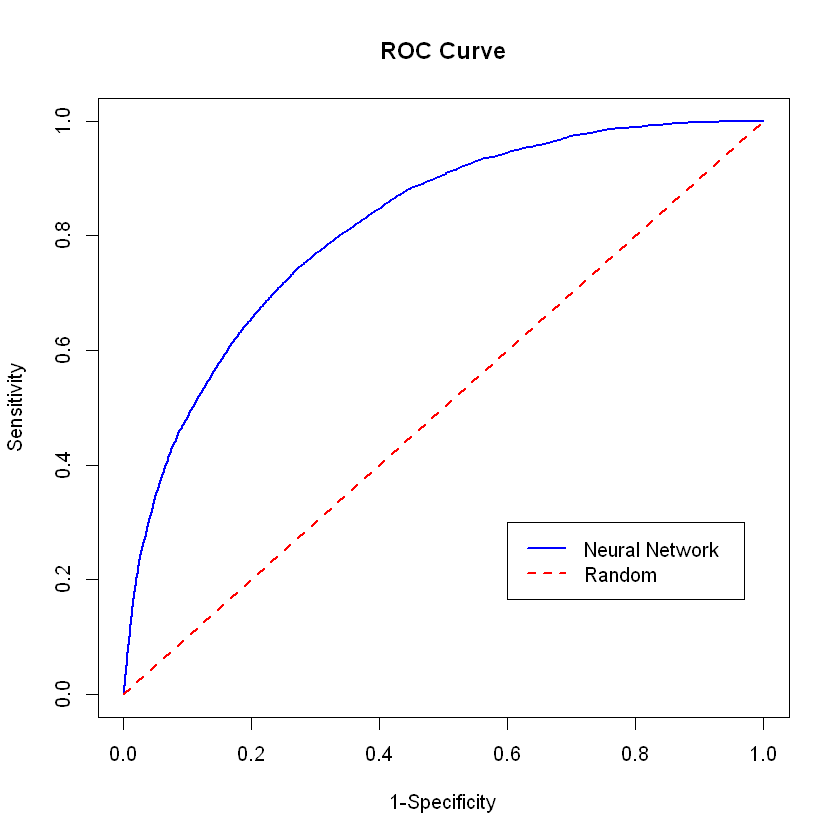

In [34]:
## ROC and AUC

library(ROCR) #install.packages("ROCR")

pred = prediction(p.nn, gdat$y)

perf = performance(pred, "tpr","fpr")
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.6, 0.3, legend = c("Neural Network","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC

> 또한 ROC, AUC curve를 미루어 봤을 때, random prediction 보다 훨씬 우수한 모델임을 알 수 있습니다. 하지만 AUC는 모든 모델 중에서 가장 낮은 수준입니다. 

## 2. Partitioning

In [47]:
# train/test split 

set.seed(123)
V = 2
n =  NROW(gdat)
id = sample(1:V, n, prob = c(0.7,0.3), replace = T) # Partitioning 7:3
ii = which(id==1)
bank2.train = gdat[ii,]
bank2.test  = gdat[-ii,]

In [54]:
gn = names(bank2.train)
f = as.formula(paste("y ~", paste(gn[!gn %in% "y"], collapse = " + ")))
fit.nn = nnet(f, data = bank2.train, size=4)      # 은닉층의 개수를 4로 설정 

# weights:  25
initial  value 21968.493161 
iter  10 value 9885.133641
iter  20 value 9437.842094
iter  30 value 9107.343909
iter  40 value 8974.639082
iter  50 value 8939.048414
iter  60 value 8934.776326
iter  70 value 8927.884489
iter  80 value 8919.451577
iter  90 value 8912.618099
iter 100 value 8905.272695
final  value 8905.272695 
stopped after 100 iterations


In [55]:
## Predicting
cutoff = 0.5
p.test.nn = predict(fit.nn, german2.test)
yhat.test.nn = ifelse(p.test.nn > cutoff, 1, 0)

ctable = table(german2.test$y, yhat.test.nn, dnn=c("Actual","Predicted"))
print(ctable) # classification table  

      Predicted
Actual     0     1
     0 11605   200
     1  1249   297


> 앞선 NO partition 결과와 비슷하게 Prediction 결과 실제로 정기예금에 가입하지 않았는데 가입했다고 예측한 오분류보다, 가입했는데 가입하지 않았다고 예측한 오분류가 약 6배 더 많습니다. 역시 이는 앞서 LDA, KNN 등의 모델보다 더욱 높은 오분류 양상으로 그 원인은 NN의 연산량을 고려해 bank data의 변수를 4가지로 제약하여 나타난 것으로 추정됩니다. 하지만 앞선 NO partition 분석보다 오분류의 양상이 완화되었습니다. 

In [56]:
miss.err = 1-sum(diag(ctable))/sum(ctable) # Misclassification Rate
miss.err

pred.acc = 1 - miss.err #Prediction Accuracy
pred.acc  

diag(ctable)[2]/apply(ctable, 1, sum)[2] # Sensitivity
diag(ctable)[1]/apply(ctable, 1, sum)[1] # Specificity

[1] 0.1085312

[1] 0.8914688

1 
0.1921087

0 
0.983058

> 역시 앞선 No partition 결과와 같이 민감도 또한 매우 낮은 수치를 보이고 있습니다. 다만 민감도 측면에서 앞선 No partition 분석보다 좋은 결과를 보였습니다. 이는 실제로 정기예금에 가입하지 않았는데 가입했다고 예측한 오분류보다, 가입했는데 가입하지 않았다고 예측한 오분류가 완화되었음을 나타내는 metric 입니다. 

[[1]]
[1] 0.83046

[[1]]
[1] 0.8342774

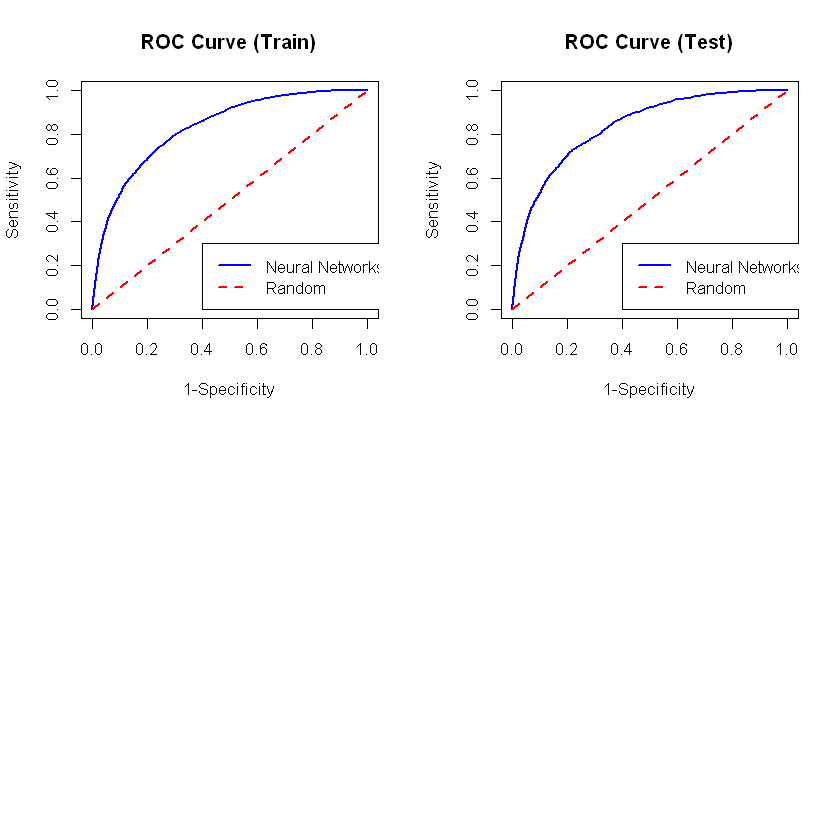

In [57]:
cutoff = 0.5
par(mfrow = c(2,2))

#Train 
p.train.nn = predict(fit.nn, german2.train)
yhat.train.nn = ifelse(p.train.nn > cutoff, 1, 0)
pred = prediction(p.train.nn, german2.train$y)

perf = performance(pred, "tpr","fpr")
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve (Train)") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.4, 0.3, legend = c("Neural Networks","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC


#Test
p.test.nn = predict(fit.nn, german2.test)
yhat.test.nn = ifelse(p.test.nn > cutoff, 1, 0)
pred = prediction(p.test.nn, german2.test$y)

perf = performance(pred, "tpr","fpr")
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve (Test)") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.4, 0.3, legend = c("Neural Networks","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC

> Train과 test data의 ROC curve fitting 결과 두 모델 모두 random prediction 보다 좋은 성능을 보임을 알 수 있습니다. 또한 Train, test의 AUC가 비슷한 것으로 보아 overfitting도 발생하지 않았음을 알 수 있습니다. 

## 3. CV

In [58]:
cutoff = 0.5

V = 5 #V-fold CV
miss.err.train = 0
miss.err.test = 0

set.seed(1234)
id = sample(1:V, nrow(bank), replace = T)

for(i in 1:V) {
  
  print(i)

  ## Data partitioning 

  bank2.train = gdat[id != i,] 
  bank2.test  = gdat[id == i,] 

  ## Model fitting

  gn = names(bank2.train)
  f = as.formula(paste("y ~", paste(gn[!gn %in% "y"], collapse = " + ")))
  fit.nn = nnet(f, data = bank2.train, size=4)  #1 hidden neuron

  ## Predicting and Evaluating

  p.test.nn = predict(fit.nn, bank2.test)  
  yhat.test.nn = ifelse(p.test.nn > cutoff, 1, 0)
  miss.err.test = miss.err.test + mean(bank2.test$y != yhat.test.nn)
  
}

cv.err.test = miss.err.test/ V; cv.err.test # CV test error

[1] 1
# weights:  25
initial  value 18383.760946 
iter  10 value 10730.997216
iter  20 value 10519.038852
iter  30 value 10190.628529
iter  40 value 10086.535048
iter  50 value 10032.577351
iter  60 value 10014.448570
iter  70 value 10010.143117
iter  80 value 9991.789001
iter  90 value 9964.739839
iter 100 value 9934.080912
final  value 9934.080912 
stopped after 100 iterations
[1] 2
# weights:  25
initial  value 26405.246720 
iter  10 value 10864.852282
iter  20 value 10395.207084
iter  30 value 10084.773816
iter  40 value 10040.017883
iter  50 value 10024.416106
iter  60 value 10008.020627
iter  70 value 9986.495648
iter  80 value 9969.193001
iter  90 value 9909.503617
iter 100 value 9893.591266
final  value 9893.591266 
stopped after 100 iterations
[1] 3
# weights:  25
initial  value 50137.357539 
iter  10 value 11252.774921
iter  20 value 10675.725836
iter  30 value 10513.217350
iter  40 value 10245.490863
iter  50 value 10166.091873
iter  60 value 10157.983401
iter  70 value 1015

[1] 0.110348

> 10 fold로 cross validation 한 결과 앞선 두 분석보다 약간 높은 error를 얻었음을 확인했습니다. 